# Lab 8 Report:
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction:
https://canvas.uw.edu/files/106242897/download?download_frd=1

### Team Members: Marno Bosch, Justin Lynch

### Dataset for your project: HEP5_ElectronEnergy

---

## Understanding the Data

Our dataset consists of 25,000 sets of 4 images (size 56x11). Each set of 4 images represent a supercluster event, which is a clustering of energy deposits in the electromagnetic calorimeter. The 4 images are generated from the ECAL in the ATLAS detector, the 1st coming from the presampler (improves energy resolution), and the remaining 3 coming from the 3 layers in the endcap region. The cells in the ECAL can be treated as pixels of an image, with each layer corresponding to an image channel (total of 4 channels). Thus, the features we are looking for are the intensities of the energy deposits in each cell. The more bright a pixel is, the more energy that was deposited in that cell during the electromagnetic shower.

## Understanding the Task

Our neural network is trying to address a regression task of reconstructing electron energy from ECAL images. By solving this problem with deep learning, we hope to accurately measure the energy of electrons in a fast and automated way. We want out model to output predictions that are close to the target electron energy values.

For this regression task, we are using our own loss function, which looks at the Mean Absolute Percentage Error for the predicted and target values.

## Developing an initial plan for your project

Input = 4 channel images of supercluster events

Output = predicted electron energy for the showers

Loss Function = MAPE

CNN architecture with convolutional, max-pooling, and dense fully-connected layers.

---------------------------------------------------------------------------------------------------------------
Friday - Load the data, do some preparation and visualization. Meet for lightning talk slides and some coding

Monday - Basic architecture

Wednesday - Working architecture

Friday - Complete the final project and print the poster for 5/28

# Lab 9 Report:
## Final Project Codebase

## Project Title: Same as your poster title

Imports

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

## Prepare Data

In [2]:
# Load the data file and create arrays for the features and targets

with h5py.File('HEP5_ElectronEnergy.h5', 'r') as f:
    # List all groups and datasets in the file
    print("Groups and Datasets in HDF5 file:")
    for name in f:
        print(name)

    # Assuming the file contains 'images' and 'targets' datasets
    images = f['em_endcap']
    targets = f['targets']

    # Read the data into NumPy arrays
    images_data = images[()]
    targets_data = targets[()]

Groups and Datasets in HDF5 file:
em_endcap
targets


In [3]:
# Print the shape of the data
print("Shape of the images dataset:", images_data.shape)
print("Shape of the targets dataset:", targets_data.shape)

# Print first few targets to understand the values
print("First 10 targets:", targets_data[:10])

Shape of the images dataset: (25000, 56, 11, 4)
Shape of the targets dataset: (25000,)
First 10 targets: [165.20587  124.791115  48.392033 199.89279  121.880875 474.84882
 177.1261    26.522882 152.45192   93.09003 ]


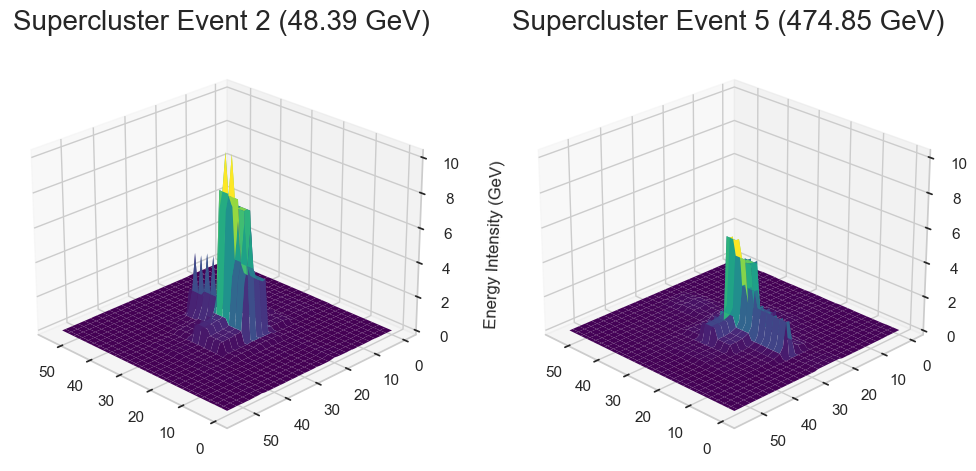

In [35]:
# Create plots to visualize the features in our dataset

# Extract and upsample the first event image
event_image_1 = images_data[2]
img_1 = np.sum(event_image_1[:, :, 0:4], axis=2)

# Convert image to tensor and unsqueeze dimensions to match (N, C, H, W) format
img_tensor_1 = torch.tensor(img_1).unsqueeze(0).unsqueeze(0).float()

# Upsample using PyTorch
upsampled_tensor_1 = torch.nn.Upsample(size=(56, 55))(img_tensor_1)
upsampled_img_1 = upsampled_tensor_1.squeeze().numpy()
image_array_1 = upsampled_img_1

# Extract and upsample the second event image
event_image_2 = images_data[5]
img_2 = np.sum(event_image_2[:, :, 0:4], axis=2)

# Convert image to tensor and unsqueeze dimensions to match (N, C, H, W) format
img_tensor_2 = torch.tensor(img_2).unsqueeze(0).unsqueeze(0).float()

# Upsample using PyTorch
upsampled_tensor_2 = torch.nn.Upsample(size=(56, 55))(img_tensor_2)
upsampled_img_2 = upsampled_tensor_2.squeeze().numpy()
image_array_2 = upsampled_img_2

# Plotting the 3D surfaces
fig = plt.figure(figsize=(12, 6))

# Plot the first image
ax1 = fig.add_subplot(121, projection='3d')
rows_1, cols_1 = image_array_1.shape
x_1 = np.arange(0, cols_1)
y_1 = np.arange(0, rows_1)
x_1, y_1 = np.meshgrid(x_1, y_1)
z_1 = image_array_1
surf_1 = ax1.plot_surface(x_1, y_1, z_1, cmap='viridis', edgecolor='none')
ax1.set_zlabel('Energy Intensity (GeV)', rotation=90, labelpad=10)
ax1.set_title('Supercluster Event 2 (48.39 GeV)', fontsize=20)

# Plot the second image
ax2 = fig.add_subplot(122, projection='3d')
rows_2, cols_2 = image_array_2.shape
x_2 = np.arange(0, cols_2)
y_2 = np.arange(0, rows_2)
x_2, y_2 = np.meshgrid(x_2, y_2)
z_2 = image_array_2
surf_2 = ax2.plot_surface(x_2, y_2, z_2, cmap='viridis', edgecolor='none')
ax2.set_zlabel('Energy (GeV)', rotation=90)
ax2.set_title('Supercluster Event 5 (474.85 GeV)', fontsize=20)

# Determine the global z-axis limits
z_min = min(z_1.min(), z_2.min())
z_max = max(z_1.max(), z_2.max())

# Set the same z-axis limits for both plots
ax1.set_zlim(z_min, z_max)
ax2.set_zlim(z_min, z_max)

# Set the viewing angle for both plots
ax1.view_init(elev=25, azim=135)
ax2.view_init(elev=25, azim=135)

# Show the plot
# plt.tight_layout()
plt.show()

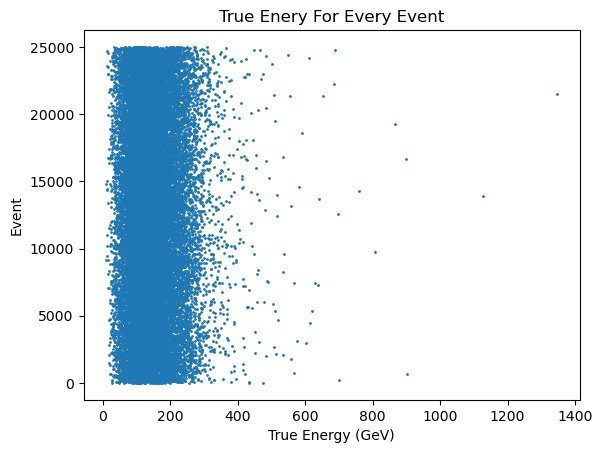

In [5]:
# Visualize the energy values to see what are the most common values

plt.scatter(targets_data, list(range(len(targets_data))), s=1)
plt.title('True Enery For Every Event')
plt.xlabel('True Energy (GeV)')
plt.ylabel('Event')
plt.show()

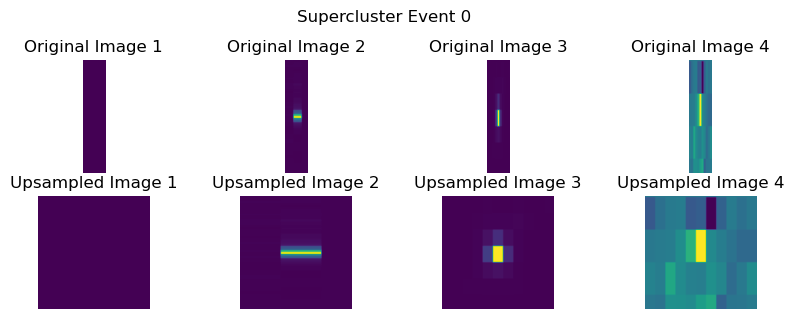

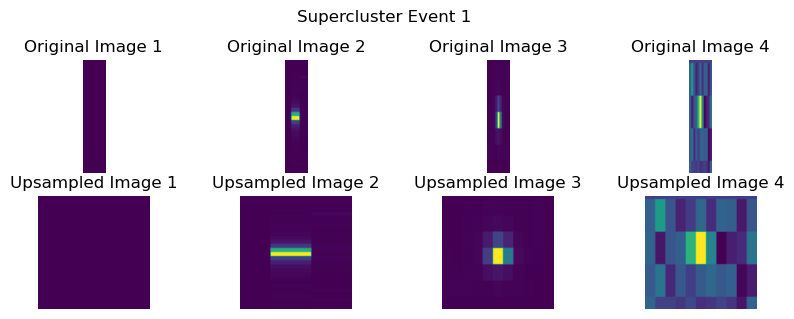

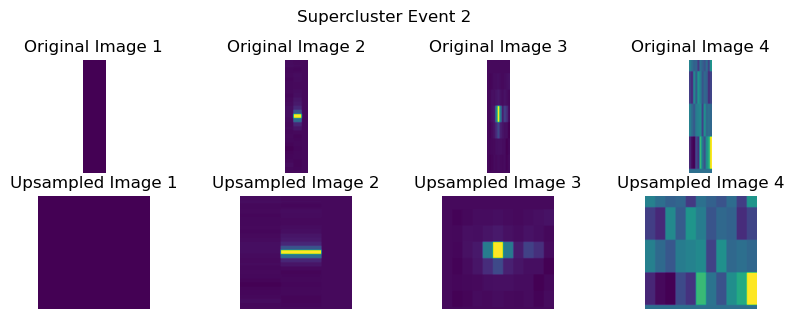

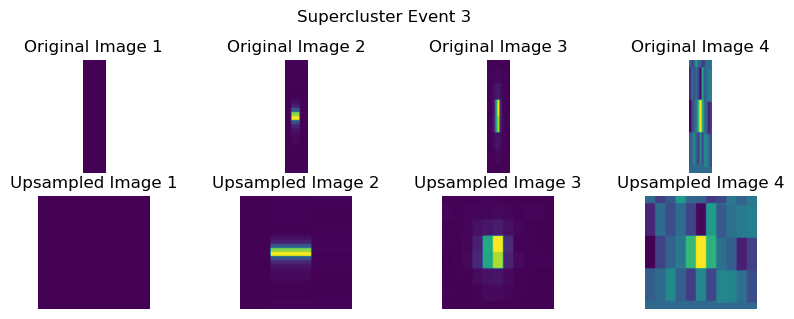

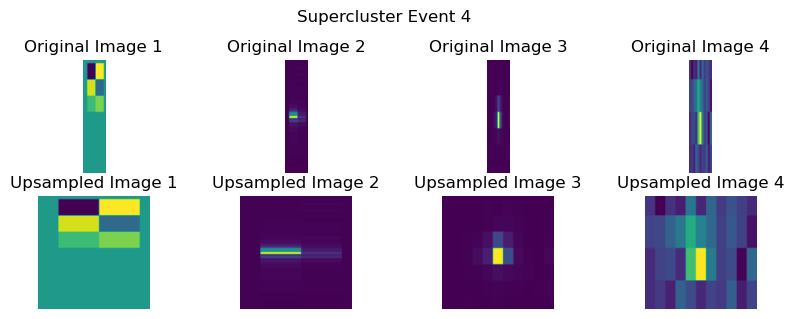

In [6]:
# Visualize the upsampled images

# Create a new array for upsampled images
upsampled_images_data = np.zeros((images_data.shape[0], 56, 55, images_data.shape[3]))

# Iterate over each supercluster event
for i in range(5):
    # Get the images for the current supercluster event
    event_images = images_data[i]
    
    # Create a new figure with increased size
    plt.figure(figsize=(10, 5))  # Adjust the width and height as needed
    
    # Plot all four images for the current event
    for j in range(4):
        img = event_images[:, :, j]
    
        # Convert image to tensor and unsqueeze dimensions to match (N, C, H, W) format
        img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
        
        # Upsample using PyTorch
        upsampled_tensor = torch.nn.Upsample(size=(56,55))(img_tensor)
        
        # Convert back to numpy array and remove extra dimensions
        upsampled_img = upsampled_tensor.squeeze().numpy()
        
        # Store the upsampled image in the new array
        upsampled_images_data[i, :, :, j] = upsampled_img
        
        # Display the original image
        plt.subplot(3, 4, j+1)
        plt.imshow(img)
        plt.title(f'Original Image {j+1}')
        plt.axis('off')

        # Display the upsampled image
        plt.subplot(3, 4, j+5)
        plt.imshow(upsampled_img)
        plt.title(f'Upsampled Image {j+1}')
        plt.axis('off')
    
    plt.suptitle(f'Supercluster Event {i}')
    plt.show()


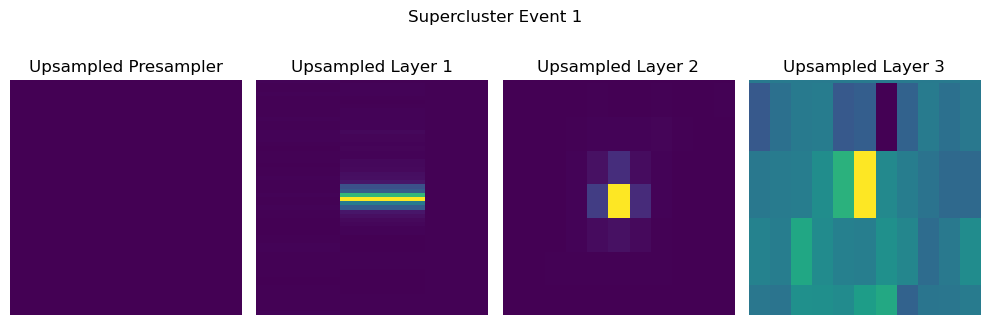

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the labels for each layer
layer_labels = ['Presampler', 'Layer 1', 'Layer 2', 'Layer 3']

# Select a specific supercluster event (e.g., the first one)
event_index = 0  # Change this index to visualize a different supercluster event
event_images = images_data[event_index]

# Create a new figure with increased size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Iterate over each layer image in the current supercluster event
for j in range(4):
    img = event_images[:, :, j]
    
    # Convert image to tensor and unsqueeze dimensions to match (N, C, H, W) format
    img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
    
    # Upsample using PyTorch
    upsampled_tensor = torch.nn.Upsample(size=(56, 55))(img_tensor)
    
    # Convert back to numpy array and remove extra dimensions
    upsampled_img = upsampled_tensor.squeeze().numpy()
    
    # Display the upsampled image
    plt.subplot(2, 4, j+1)
    plt.imshow(upsampled_img, cmap='viridis')
    plt.title(f'Upsampled {layer_labels[j]}')
    plt.axis('off')

plt.suptitle(f'Supercluster Event {event_index + 1}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


In [8]:
# Data augmentation to make the network more robust

plt.rcParams["savefig.bbox"] = 'tight'

# We compose several transforms into one action to act onto the dataset to create a set of augmented images
# Images are randomly flipped and cropped
aug = 15000 # Parameter for the amount of news events to be generated with transforms
transform1 = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAdjustSharpness(2, p=1),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])
transform2 = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAdjustSharpness(0, p=0.5),
    v2.RandomVerticalFlip(p=1),
    v2.ToDtype(torch.float32, scale=True),
])
# We create a new set of the transformed images
aug1 = transform1(images_data[:aug])
aug2 = transform2(images_data[-aug:])
# Adding augmented data to original data
images_data = np.concatenate((aug1, images_data))
targets_data = np.concatenate((targets_data[:aug], targets_data))
images_data = np.concatenate((aug2, images_data))
targets_data = np.concatenate((targets_data[-aug:], targets_data))  # We now have 40,000 total events to use

# Reshape features via flattening the images to perform scaling with 2D arrays
flat_image_data = images_data.reshape(25000 + 2 * aug, 56 * 11 * 4)

In [9]:
# Normalize the dataset

# Define scaling function, normalize the data, and reshape back to 4D array
scaler = StandardScaler()
train_image_data = scaler.fit_transform(flat_image_data).reshape(25000 + 2 * aug, 56, 11, 4)

# Transpose data to correct shape
train_image_data = train_image_data.transpose(0, 3, 1, 2)
print(train_image_data.shape)

(55000, 4, 56, 11)


In [10]:
# Split the data into training, testing, validating (80, 10, 10 split)

from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
x_train, x_remaining, y_train, y_remaining = train_test_split(train_image_data, targets_data, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size=0.33, random_state=42)

# Print the shapes of each
print("Shape of training set (x_train):", x_train.shape)
print("Shape of training labels (y_train):", y_train.shape)
print("Shape of validation set (x_val):", x_val.shape)
print("Shape of validation labels (y_val):", y_val.shape)
print("Shape of test set (x_test):", x_test.shape)
print("Shape of test labels (y_test):", y_test.shape)

Shape of training set (x_train): (38500, 4, 56, 11)
Shape of training labels (y_train): (38500,)
Shape of validation set (x_val): (11055, 4, 56, 11)
Shape of validation labels (y_val): (11055,)
Shape of test set (x_test): (5445, 4, 56, 11)
Shape of test labels (y_test): (5445,)


## Define Model

In [11]:
class CNNModel(torch.nn.Module):
    def __init__(self):

        super(CNNModel, self).__init__()
        
        # height = (input height + 2*padding - kernel)/stride + 1
        # width = (input width + 2*padding - kernel)/stride + 1

        # Upsample to 56x55
        self.upsample = torch.nn.Upsample(size=(56, 55)) 

        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layers
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(3 * 3 * 256, 1024)
        self.fc2 = torch.nn.Linear(1024, 216)
        self.fc3 = torch.nn.Linear(216, 1)
        
        # Batch normalization layers
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(256)

    def forward(self, x):

        # Upsampling
        x = self.upsample(x)  # 56x55 @ 4

        # Convolutional layers with ReLU activation and max pooling
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))  # 56x55 @ 16
        x = self.pool(x)  # 28x27 @ 16
 
        x = torch.nn.functional.relu(self.conv2(x))  # 28x27 @ 32
        x = self.pool(x)  # 14x13 @ 32

        x = torch.nn.functional.relu(self.conv3(x))  # 14x13 @ 64
        x = torch.nn.functional.relu(self.conv4(x))  # 14 13 @ 128
        x = self.pool(x)  # 7x6 @ 128

        x = torch.nn.functional.relu(self.bn2(self.conv5(x)))  # 7x6 @ 256
        x = self.pool(x)  # 3x3 @ 256

        # Flatten the output
        x = x.reshape(x.size(0), -1)
        
        # Fully connected layers with ReLU activation
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        
        return x

## Define Hyperparameters

In [12]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Define Mean Aboslute Percentage Error loss function
def mape_loss(y_pred, y_true):
    return torch.mean(torch.abs((y_true - y_pred) / y_true))

# Initialize your CNN model
model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient
learning_rate = 6e-3
epochs = 40
batchsize = 50

# Define loss function and optimizer
loss_func = mape_loss
# loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.cuda()

CNNModel(
  (upsample): Upsample(size=(56, 55), mode='nearest')
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=1, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Identify Tracked Values

In [13]:
# Placeholders for training loss and validation error during training

train_loss_list = []
validation_error_list = np.zeros((epochs,))

## Train Model

In [14]:
# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(x_train).float().cuda()
train_targets = torch.from_numpy(y_train).float().view(-1, 1).cuda()

validation_inputs = torch.from_numpy(x_val).float().cuda()
validation_targets = torch.from_numpy(y_val).float().view(-1, 1).cuda()

testing_inputs = torch.from_numpy(x_test).float().cuda()
testing_targets = torch.from_numpy(y_test).float().view(-1, 1).cuda()

# Use torch.split() function to split the training inputs/targets into mini-batches
# See documentation of torch.split() https://pytorch.org/docs/stable/generated/torch.split.html
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

In [15]:
# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):

    for k in range(batch_split_num):

        optimizer.zero_grad()  # separate learning for each epoch

        train_batch_outputs = model(train_batches_features[k])  # forward pass through network

        # compute and track training loss
        loss = loss_func(train_batch_outputs, train_batches_targets[k])
        train_loss_list.append(loss.item())

        # backwards propagation for changes in weights/biases and then update
        loss.backward()
        optimizer.step()

        # Print the loss for each epoch
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    # Validation error using MAPE
    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        error = loss_func(validation_targets, validation_outputs)
        validation_error_list[epoch] = error

epoch 0, loss 0.999994158744812
epoch 0, loss 0.7406813502311707
epoch 0, loss 0.6493250727653503
epoch 0, loss 0.3735383450984955
epoch 0, loss 0.48263534903526306
epoch 0, loss 0.36903658509254456
epoch 0, loss 0.47743260860443115
epoch 0, loss 0.4254172444343567
epoch 0, loss 0.36337119340896606
epoch 0, loss 0.4270397126674652
epoch 0, loss 0.3323933780193329
epoch 0, loss 0.6361181735992432
epoch 0, loss 0.3400934636592865
epoch 0, loss 0.31766965985298157
epoch 0, loss 0.28843092918395996
epoch 0, loss 0.2820283770561218
epoch 0, loss 0.2503317594528198
epoch 0, loss 0.2646773159503937
epoch 0, loss 0.40356719493865967
epoch 0, loss 0.35367751121520996
epoch 0, loss 0.28767287731170654
epoch 0, loss 0.2977084219455719
epoch 0, loss 0.21950694918632507
epoch 0, loss 0.35489538311958313
epoch 0, loss 0.21365131437778473
epoch 0, loss 0.27373871207237244
epoch 0, loss 0.22323590517044067
epoch 0, loss 0.26688891649246216
epoch 0, loss 0.2105613797903061
epoch 0, loss 0.2773052752017

## Visualize & Evaluate Model

In [16]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

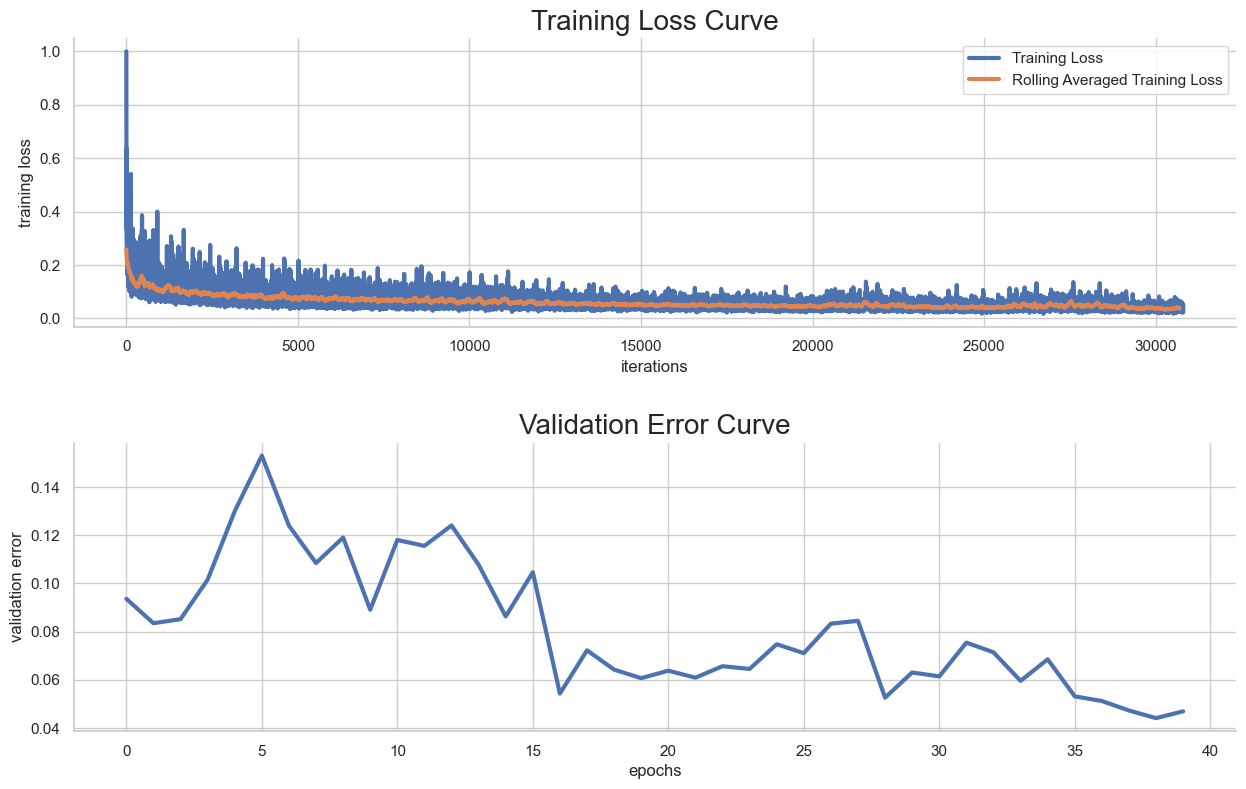

In [29]:
# Visualize training loss

plt.figure(figsize = (15, 9))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("iterations")
plt.title('Training Loss Curve', fontsize=20)
plt.legend()
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_error_list, linewidth = 3)
plt.ylabel("validation error")
plt.xlabel("epochs")
plt.title('Validation Error Curve', fontsize=20)
sns.despine()

In [18]:
# Finding the error in the prediction for the testing data
with torch.no_grad():
        prediction = model(testing_inputs)
        error = loss_func(testing_targets, prediction)

print("Test Mean Absolute Percentage Error:", error.item())

Test Mean Absolute Percentage Error: 0.048107922077178955


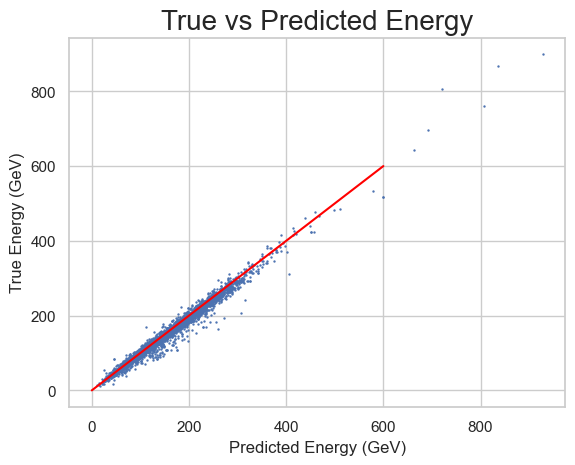

In [24]:
# Plot the expected values vs predicted values to see if we have a 45 degree linear line

# Convert tensors to numpy arrays
prediction_np = prediction.cpu().numpy()
testing_targets_np = testing_targets.cpu().numpy()

# Plot the scatter plot of expected vs predicted values
plt.scatter(prediction_np, testing_targets_np, s=0.5)
plt.xlabel('Predicted Energy (GeV)')
plt.ylabel('True Energy (GeV)')
plt.title('True vs Predicted Energy', fontsize=20)

# Create x values
x_values = np.linspace(0, 600)  # Adjust the range as needed

# Calculate corresponding y values
y_values = x_values

# Plot the linear line
plt.plot(x_values, y_values, color='red')

plt.show()

In [20]:
# Print the predictions and targets for comparision

# Randomly select 20 indices
random_indices = np.random.choice(2475, 20, replace=False)

# Convert to numpy arrays
pred_np = prediction_np[random_indices]
targets_np = testing_targets_np[random_indices]

# Calculate the differences
differences = np.abs(pred_np - targets_np)

# Print indices, predictions, targets, and differences
print(f"{'Index':<6}  |  {'Prediction':<10}  |  {'Target':<10}  |  {'Difference':<10}")
print("-" * 48)
for idx, pred, target, diff in zip(random_indices, pred_np, targets_np, differences):
    print(f"{idx:<6}  |  {pred.item():<10.4f}  |  {target.item():<10.4f}  |  {diff.item():<10.4f}")

Index   |  Prediction  |  Target      |  Difference
------------------------------------------------
364     |  128.2287    |  134.4324    |  6.2037    
1835    |  139.7335    |  135.2971    |  4.4365    
987     |  146.4451    |  142.3302    |  4.1149    
376     |  254.1733    |  246.2166    |  7.9568    
2158    |  129.9457    |  136.1474    |  6.2017    
49      |  152.5138    |  150.0167    |  2.4971    
1128    |  84.4773     |  77.6755     |  6.8018    
1024    |  115.7865    |  122.4049    |  6.6185    
45      |  67.3520     |  77.2923     |  9.9403    
1069    |  184.4966    |  173.9871    |  10.5095   
173     |  96.9428     |  95.6469     |  1.2958    
256     |  134.1986    |  84.9007     |  49.2979   
658     |  159.1266    |  158.0040    |  1.1226    
187     |  233.2128    |  233.2504    |  0.0376    
2118    |  108.1286    |  99.6227     |  8.5059    
1840    |  233.5466    |  231.8350    |  1.7116    
823     |  182.6218    |  171.6989    |  10.9228   
1360    |  132.

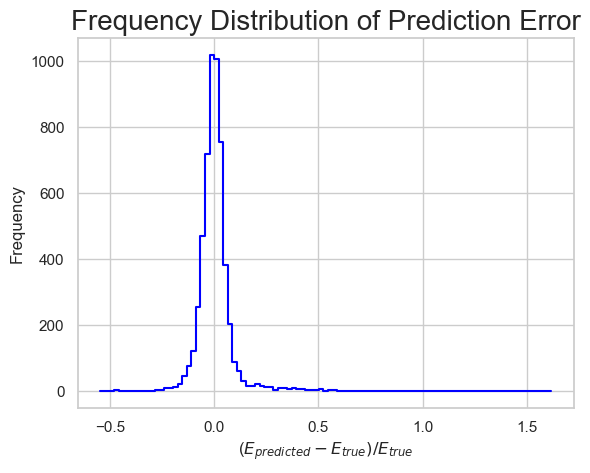

In [30]:
# Visualize the spread in the error

# Compute the array of (pred - truth) / truth
error_ratio = (prediction_np - testing_targets_np) / testing_targets_np

# Compute the histogram of error_ratio
values, bins = np.histogram(error_ratio, bins=100)


# Plot the segmented line plot
plt.step(bins[:-1], values, color='blue')
plt.xlabel('($E_{predicted} - E_{true}) / E_{true}$')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Prediction Error', fontsize=20)
plt.grid(True)
plt.show()